In [1]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tf.logging.set_verbosity(tf.logging.INFO)

In [3]:
def cnn_model_fn(features,labels,mode):
	#Correct dimensions
	input_layer = tf.reshape(features["x"], [-1,28,28,1])

	#Define Model
	conv1 = tf.layers.conv2d(
		inputs = input_layer,
		filters=32,
		kernel_size=[5,5],
		padding="same", 
		activation=tf.nn.relu)

	pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2],strides=2)

	conv2 = tf.layers.conv2d(
		inputs=pool1,
		filters=64,
		kernel_size=[5,5],
		padding="same",
		activation=tf.nn.relu)

	pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2],strides=2)

	pool2_flat = tf.reshape(pool2, [-1,7*7*64])
	dense = tf.layers.dense(inputs=pool2_flat, units=1024,activation=tf.nn.relu)
	dropout = tf.layers.dropout(
		inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
	logits = tf.layers.dense(inputs=dropout,units=10)

	#Predictions
	predictions = {
		"classes":tf.argmax(input=logits,axis=1),
		"probabilities": tf.nn.softmax(logits, name="softmax_tensor")
	}

	#Predict Mode
	if mode == tf.estimator.ModeKeys.PREDICT :
		return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

	#Loss (eval and train both)
	# One hot labels ? 
	# onehot_labels = tf.one_hot(indices=tf.cast(labels,tf.int32), depth=10)
	loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits) # onehot_labels=onehot_labels

	#Train
	if mode == tf.estimator.ModeKeys.TRAIN :
		optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
		train_op = optimizer.minimize(
			loss = loss,
			global_step = tf.train.get_global_step())
		return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

	#Eval
	eval_metric_ops = {
		"accuracy" : tf.metrics.accuracy(
			labels=labels, predictions=predictions["classes"])}
	return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
train_data = mnist.train.images
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


16 Random images and their labels


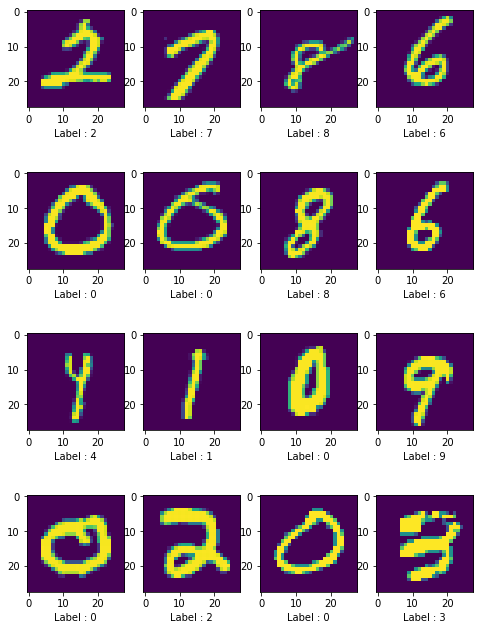

In [6]:
#Preview random image
fig = plt.figure(figsize=(8,8))
plt.subplots_adjust(top=1.2)
col = 4
row = 4
print(str(col*row)+" Random images and their labels")
ri = random.sample(range(0,len(train_data)),col*row)
rii = 0
for i in range(1, col*row+1):
  img = np.copy(train_data[ri[rii]])
  img = img.reshape((28,28))
  img = np.asarray(img, dtype=np.float32)
  fig.add_subplot(row,col,i)
  x_label = 'Label : ' + str(train_labels[ri[rii]])
  plt.xlabel(x_label)
  plt.imshow(img, interpolation = 'nearest')
  rii = rii + 1
_ = plt.show()

In [7]:
mnist_classifier = tf.estimator.Estimator(
model_fn = cnn_model_fn, model_dir = "/tmp/mnist_convnet_modelpr")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/mnist_convnet_modelpr', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fad06a7ba20>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [8]:
# Logging predictions
tensors_to_log = {"probabilities" : "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
  tensors = tensors_to_log, every_n_iter=500)

In [9]:
#Training
train_input_fn = tf.estimator.inputs.numpy_input_fn(
  x = {"x": train_data},
  y=train_labels,
	batch_size=128,
	num_epochs = 10,
	shuffle=True)
mnist_classifier.train(input_fn = train_input_fn, hooks = [logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/mnist_convnet_modelpr/model.ckpt.
INFO:tensorflow:probabilities = [[0.10659222 0.10483029 0.09066836 ... 0.09512464 0.11550292 0.09699661]
 [0.09612888 0.11424766 0.08816691 ... 0.10810445 0.10691498 0.0950122 ]
 [0.09678549 0.11276269 0.09009096 ... 0.10688423 0.1057261  0.09530787]
 ...
 [0.10892161 0.11128951 0.09954917 ... 0.08338356 0.10962592 0.08133693]
 [0.10788575 0.10470948 0.08668446 ... 0.09587133 0.10356233 0.09514458]
 [0.09853997 0.09652935 0.09207782 ... 0.09598948 0.12102686 0.08984394]]
INFO:tensorflow:loss = 2.3235822, step = 1
INFO:tensorflow:global_step/sec: 1.99846
INFO:tensorflow:loss = 2.0272045, step = 101 (50.038 sec)
INFO:tensorflow:global_step/sec: 1.85846
INFO:tensorflow:los

INFO:tensorflow:loss = 0.0674668, step = 3701 (49.174 sec)
INFO:tensorflow:global_step/sec: 2.00122
INFO:tensorflow:loss = 0.07927959, step = 3801 (49.970 sec)
INFO:tensorflow:global_step/sec: 2.01801
INFO:tensorflow:loss = 0.07494091, step = 3901 (49.554 sec)
INFO:tensorflow:global_step/sec: 1.93374
INFO:tensorflow:probabilities = [[0.00060723 0.00000083 0.9911618  ... 0.00001834 0.00779005 0.00024694]
 [0.00508307 0.00008368 0.00008998 ... 0.30250007 0.00021835 0.6882529 ]
 [0.0000018  0.00000576 0.00032815 ... 0.05877894 0.00030658 0.12432382]
 ...
 [0.         0.00000028 0.00000001 ... 0.00000211 0.00000402 0.00053092]
 [0.00000698 0.00001025 0.00000095 ... 0.00066589 0.00025255 0.00149377]
 [0.00001095 0.00004838 0.00018946 ... 0.00012632 0.00081564 0.00382439]] (253.032 sec)
INFO:tensorflow:loss = 0.09973985, step = 4001 (51.715 sec)
INFO:tensorflow:global_step/sec: 2.01088
INFO:tensorflow:loss = 0.093766615, step = 4101 (49.727 sec)
INFO:tensorflow:global_step/sec: 2.00492
INFO:

In [10]:
#Eval
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
	x={"x":eval_data},
	y=eval_labels,
	num_epochs=1,
	shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)
print()
print("The accuracy on Test Dataset is : "+str(eval_results["accuracy"]*100) + "% and the loss is : " + str(eval_results["loss"]))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-14-14:06:37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_modelpr/model.ckpt-4297
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-07-14-14:06:51
INFO:tensorflow:Saving dict for global step 4297: accuracy = 0.9799, global_step = 4297, loss = 0.06461509
{'accuracy': 0.9799, 'loss': 0.06461509, 'global_step': 4297}

The accuracy on Test Dataset is : 97.99000024795532% and the loss is : 0.06461509


16 Random images and their labels and predicted class
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_modelpr/model.ckpt-4297
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


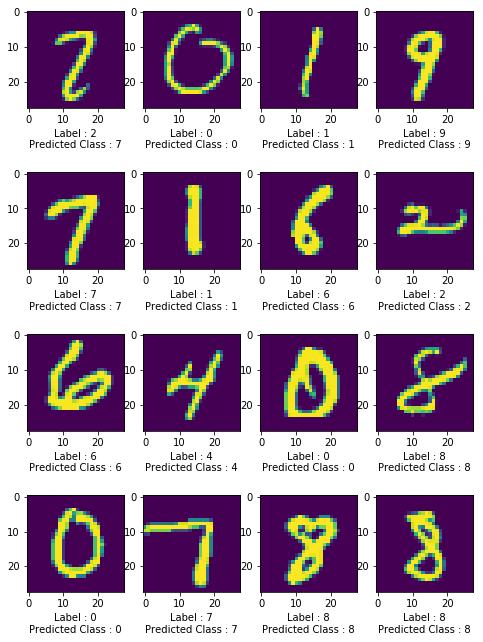

In [11]:
#Preview random image
fig = plt.figure(figsize=(8,8))
plt.subplots_adjust(top=1.2)
col = 4
row = 4
print(str(col*row)+" Random images and their labels and predicted class")
#Generating random numbers, these numbers will be the indices of the images chosen
ri = random.sample(range(0,len(eval_data)),col*row)

#predict_x stores images chosen
predict_x = []
for i in ri:
  predict_x.append(np.array(eval_data[i],dtype=np.float32))

#Estimator to predict classes
predict_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x":np.array(predict_x,dtype=np.float32)},shuffle=False)
predictions = mnist_classifier.predict(input_fn = predict_input_fn)
#Storing the classes predicted
predicted_class = []
for pred_dict in predictions:
  predicted_class.append(pred_dict['classes'])

#Plotting
rii = 0
for i in range(1, col*row+1):
  img = np.copy(eval_data[ri[rii]])
  img = img.reshape((28,28))
  img = np.asarray(img, dtype=np.float32)
  fig.add_subplot(row,col,i)
  x_label = 'Label : ' + str(eval_labels[ri[rii]]) + "\n" + "Predicted Class : " + str(predicted_class[rii])
  plt.xlabel(x_label)
  plt.imshow(img, interpolation = 'nearest')
  rii = rii + 1
_ = plt.show()